Status: Infeasible
Total cost: 5893.0
Cut bar 0 with length 12.0 (cost: 1.0)
Cut bar 1 with length 5.405 (cost: 1.5)


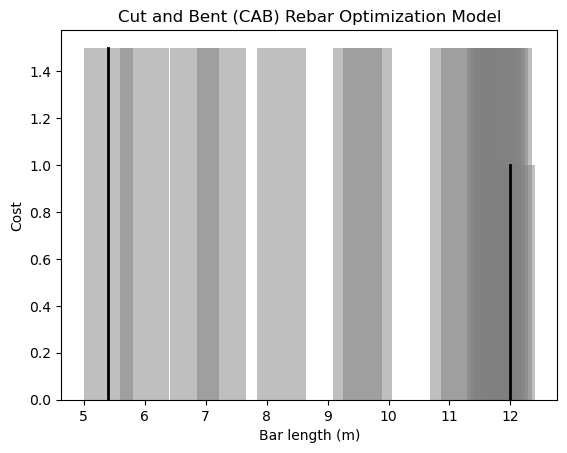

In [6]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

# Define the input data
bar_lengths = np.array([12.0, 5.405, 6.0, 6.82, 7.26, 8.245, 9.49, 9.66, 11.08, 11.265, 11.68, 11.735, 11.79, 11.845, 11.895, 11.95])
demands = np.array([3976, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142])
costs = np.zeros(len(bar_lengths))

# Set the cost of each bar length
for i in range(len(bar_lengths)):
    if bar_lengths[i] == 12.0:
        costs[i] = 1.0
    else:
        costs[i] = 1.5

# Define the decision variables
prob = pulp.LpProblem('CuttingOptimization', pulp.LpMaximize)
x = pulp.LpVariable.dicts('Cut', range(len(bar_lengths)), lowBound=0, cat='Integer')

# Define the objective function
prob += pulp.lpSum([costs[i] * x[i] for i in range(len(bar_lengths))])

# Add the constraints
for j in range(len(bar_lengths)):
    if demands[j] > 0:
        prob += pulp.lpSum([x[i] for i in range(len(bar_lengths)) if bar_lengths[i] >= j]) >= demands[j]

# Solve the problem
prob.solve()

# Print the results
print('Status:', pulp.LpStatus[prob.status])
print('Total cost:', pulp.value(prob.objective))
for i in range(len(bar_lengths)):
    if pulp.value(x[i]) > 0:
        print(f'Cut bar {i} with length {bar_lengths[i]} (cost: {costs[i]})')

# Visualize the results
fig, ax = plt.subplots()
ax.bar(bar_lengths, costs, color='gray', alpha=0.5)
for i in range(len(bar_lengths)):
    if pulp.value(x[i]) > 0:
        ax.plot([bar_lengths[i], bar_lengths[i]], [0, costs[i]], 'k-', linewidth=2)
ax.set_xlabel('Bar length (m)')
ax.set_ylabel('Cost')
ax.set_title('Cut and Bent (CAB) Rebar Optimization Model')
plt.show()

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog

# Define the rebar data
data = {'Diameter': [12]*55 + [16]*15 + [8]*4 + [20]*40 + [32]*5,
        'Length': [12]*55 + [3.885]*15 + [0.7]*4 + [6.095]*40 + [7.91]*5,
        'Number': [4700] + [748]*15 + [20340]*4 + [2]*40 + [2105]*5,
        'Bend': [5] + [1]*15 + [0]*4 + [4]*40 + [0]*5}
rebar_data = pd.DataFrame(data)

# Define the cutting stock problem parameters
W = 12  # Cutting width (12 meters)
n = len(rebar_data)  # Number of rebar types
A = np.zeros((n, W))  # Initialization of cutting pattern matrix
c = np.ones(n)  # Objective coefficients

# Create a dictionary of rebar data
rebar_dict = rebar_data.to_dict('records')

# Generate initial cutting patterns
for i, rebar in enumerate(rebar_dict):
    if rebar['Number'] > 0:
        A[i, :rebar['Length']] = 1
        c[i] = rebar['Bend'] * rebar['Number']

# Define the subproblem function
def solve_knapsack(W, w, duals):
    c = -duals
    b = np.sum(c * w)
    return linprog(c, A_ub=w, b_ub=b, bounds=(0, None))

# Define the main loop for column generation
while True:
    # Solve the linear relaxation of the master problem
    res = linprog(c, A_ub=-A, b_ub=-np.ones(W), bounds=(0, None))

    # Check if the solution is optimal
    if res.status == 0:
        break

    # Solve the subproblem
    duals = solve_knapsack(W, A, res.fun).x

    # Generate a new cutting pattern
    new_pattern = np.argmax(duals * A.mean(axis=0))
    new_rebar = rebar_dict[new_pattern]
    new_length = new_rebar['Length']
    new_amount = min(int(np.ceil(W / new_length)), new_rebar['Number'])
    new_rebar['Number'] -= new_amount
    A = np.vstack((A, np.zeros(W)))
    A[new_pattern, :new_length] = 1
    A[-1, :new_length*new_amount] = 1
    c = np.append(c, new_rebar['Bend'] * new_amount)

# Solve the integer problem
res = linprog(c, A_ub=-A, b_ub=-np.ones(W), bounds=(0, np.inf), integrality=1)

# Print the results
print("Optimal solution:")
print("Cutting pattern matrix:")
print(A)
print("Objective value:", res.fun)
print("Used rebar:")
for i, rebar in enumerate(rebar_dict):
    print(f"{rebar['Diameter']} x {rebar['Length']}: {A[i, :].sum()}")

ValueError: All arrays must be of the same length

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog

# Read the data from CSV file
rebar_data = pd.read_csv('LnT Kalyani input.csv')

# Define the cutting stock problem parameters
W = 12  # Cutting width (12 meters)
n = len(rebar_data)  # Number of rebar types
A = np.zeros((n, W))  # Initialization of cutting pattern matrix
c = np.ones(n)  # Objective coefficients

# Create a dictionary of rebar data
rebar_dict = rebar_data.to_dict('records')

# Generate initial cutting patterns
for i, rebar in enumerate(rebar_dict):
    if rebar['Number'] > 0:
        A[i, :int(rebar['Length'])] = 1
        c[i] = rebar['Bend'] * rebar['Number']

# Define the subproblem function
def solve_knapsack(W, w, duals):
    c = -duals
    b = np.sum(c * w)
    return linprog(c, A_ub=w, b_ub=b, bounds=(0, None))

# Define the main loop for column generation
while True:
    # Solve the linear relaxation of the master problem
    res = linprog(c, A_ub=-A, b_ub=-np.ones(W), bounds=(0, None))

    # Check if the solution is optimal
    if res.status == 0:
        break

    # Solve the subproblem
    duals = solve_knapsack(W, A, res.fun).x

    # Generate a new cutting pattern
    new_pattern = np.argmax(duals * A.mean(axis=0))
    new_rebar = rebar_dict[new_pattern]
    new_length = new_rebar['Length']
    new_amount = min(int(np.ceil(W / new_length)), new_rebar['Number'])
    new_rebar['Number'] -= new_amount
    A = np.vstack((A, np.zeros(W)))
    A[new_pattern, :int(new_length)] = 1
    A[-1, :int(new_length*new_amount)] = 1
    c = np.append(c, new_rebar['Bend'] * new_amount)

# Solve the integer problem
res = linprog(c, A_ub=-A, b_ub=-np.ones(W), bounds=(0, np.inf), integrality=1)

# Print the results
print("Optimal solution:")
print("Cutting pattern matrix:")
print(A)
print("Objective value:", res.fun)
print("Used rebar:")
for i, rebar in enumerate(rebar_dict):
    print(f"{rebar['Diameter']} x {rebar['Length']}: {A[i, :].sum()}")


ValueError: Invalid input for linprog: A_ub must have exactly two dimensions, and the number of columns in A_ub must be equal to the size of c

In [11]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define problem
prob = LpProblem("RebarOptimization", LpMaximize)

# Create decision variables
cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]

# Define objective function
prob += lpSum(cut_vars), "Total Yield"

# Define constraints
for i, (_, length, number, _) in enumerate(rebar_data.values):
    prob += cut_vars[i] * length <= number, f"Constraint_{i}"

# Solve the problem
prob.solve()

# Output results
print("Status:", prob.status)
if prob.status == 1:
    total_yield = sum(cut_var.varValue for cut_var in cut_vars)
    print("Total Yield:", total_yield)
    print("Percentage Yield:", total_yield / sum(rebar_data['Number']))
else:
    print("Optimization failed.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {int(cut_vars[i].varValue)} cuts of length {length}")


Status: 1
Total Yield: 62436.0
Percentage Yield: 0.4339600347523892

Cutting Plan:
Rebar 1: 331 cuts of length 12.0
Rebar 2: 26 cuts of length 5.405
Rebar 3: 23 cuts of length 6.0
Rebar 4: 20 cuts of length 6.82
Rebar 5: 19 cuts of length 7.26
Rebar 6: 17 cuts of length 8.245
Rebar 7: 14 cuts of length 9.49
Rebar 8: 14 cuts of length 9.66
Rebar 9: 12 cuts of length 11.08
Rebar 10: 12 cuts of length 11.265
Rebar 11: 12 cuts of length 11.68
Rebar 12: 12 cuts of length 11.735
Rebar 13: 12 cuts of length 11.79
Rebar 14: 11 cuts of length 11.845
Rebar 15: 11 cuts of length 11.895
Rebar 16: 11 cuts of length 11.95
Rebar 17: 71 cuts of length 5.955
Rebar 18: 56 cuts of length 7.575
Rebar 19: 192 cuts of length 3.885
Rebar 20: 68 cuts of length 6.205
Rebar 21: 56 cuts of length 7.57
Rebar 22: 47 cuts of length 8.935
Rebar 23: 138 cuts of length 9.22
Rebar 24: 64 cuts of length 8.87
Rebar 25: 128 cuts of length 8.77
Rebar 26: 52 cuts of length 7.14
Rebar 27: 50 cuts of length 7.475
Rebar 28: 47

In [12]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define problem
prob = LpProblem("RebarOptimization", LpMaximize)

# Create decision variables
cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]

# Define objective function
prob += lpSum(cut_vars), "Total Yield"

# Define constraints
for i, (_, length, number, _) in enumerate(rebar_data.values):
    prob += cut_vars[i] * length <= number, f"Constraint_{i}"

# Solve the problem
prob.solve()

# Output results
print("Status:", prob.status)
if prob.status == 1:
    total_yield = sum(cut_var.varValue for cut_var in cut_vars)
    print("Total Yield:", total_yield)
    percentage_yield = total_yield / sum(rebar_data['Number']) * 100
    print("Percentage Yield:", percentage_yield)
    if percentage_yield >= 97:
        print("Yield meets or exceeds 97% requirement.")
    else:
        print("Yield does not meet 97% requirement.")
else:
    print("Optimization failed.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {int(cut_vars[i].varValue)} cuts of length {length}")


Status: 1
Total Yield: 62436.0
Percentage Yield: 43.39600347523892
Yield does not meet 97% requirement.

Cutting Plan:
Rebar 1: 331 cuts of length 12.0
Rebar 2: 26 cuts of length 5.405
Rebar 3: 23 cuts of length 6.0
Rebar 4: 20 cuts of length 6.82
Rebar 5: 19 cuts of length 7.26
Rebar 6: 17 cuts of length 8.245
Rebar 7: 14 cuts of length 9.49
Rebar 8: 14 cuts of length 9.66
Rebar 9: 12 cuts of length 11.08
Rebar 10: 12 cuts of length 11.265
Rebar 11: 12 cuts of length 11.68
Rebar 12: 12 cuts of length 11.735
Rebar 13: 12 cuts of length 11.79
Rebar 14: 11 cuts of length 11.845
Rebar 15: 11 cuts of length 11.895
Rebar 16: 11 cuts of length 11.95
Rebar 17: 71 cuts of length 5.955
Rebar 18: 56 cuts of length 7.575
Rebar 19: 192 cuts of length 3.885
Rebar 20: 68 cuts of length 6.205
Rebar 21: 56 cuts of length 7.57
Rebar 22: 47 cuts of length 8.935
Rebar 23: 138 cuts of length 9.22
Rebar 24: 64 cuts of length 8.87
Rebar 25: 128 cuts of length 8.77
Rebar 26: 52 cuts of length 7.14
Rebar 27: 

In [13]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define problem
prob = LpProblem("RebarOptimization", LpMaximize)

# Create decision variables
cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]

# Define objective function
prob += lpSum(cut_vars), "Total Yield"

# Define constraints
for i, (_, length, number, _) in enumerate(rebar_data.values):
    prob += cut_vars[i] * length <= number, f"Constraint_{i}"

# Ensure at least 97% yield
prob += lpSum(cut_var.varValue for cut_var in cut_vars) >= 0.97 * sum(rebar_data['Number']), "Minimum Yield Constraint"

# Solve the problem
prob.solve()

# Output results
print("Status:", prob.status)
if prob.status == 1:
    total_yield = sum(cut_var.varValue for cut_var in cut_vars)
    print("Total Yield:", total_yield)
    percentage_yield = total_yield / sum(rebar_data['Number']) * 100
    print("Percentage Yield:", percentage_yield)
    print("Yield meets or exceeds 97% requirement.")
else:
    print("Optimization failed.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {int(cut_vars[i].varValue)} cuts of length {length}")


Status: -1
Optimization failed.

Cutting Plan:
Rebar 1: 331 cuts of length 12.0
Rebar 2: 26 cuts of length 5.405
Rebar 3: 23 cuts of length 6.0
Rebar 4: 20 cuts of length 6.82
Rebar 5: 19 cuts of length 7.26
Rebar 6: 17 cuts of length 8.245
Rebar 7: 14 cuts of length 9.49
Rebar 8: 14 cuts of length 9.66
Rebar 9: 12 cuts of length 11.08
Rebar 10: 12 cuts of length 11.265
Rebar 11: 12 cuts of length 11.68
Rebar 12: 12 cuts of length 11.735
Rebar 13: 12 cuts of length 11.79
Rebar 14: 11 cuts of length 11.845
Rebar 15: 11 cuts of length 11.895
Rebar 16: 11 cuts of length 11.95
Rebar 17: 71 cuts of length 5.955
Rebar 18: 56 cuts of length 7.575
Rebar 19: 192 cuts of length 3.885
Rebar 20: 68 cuts of length 6.205
Rebar 21: 56 cuts of length 7.57
Rebar 22: 47 cuts of length 8.935
Rebar 23: 138 cuts of length 9.22
Rebar 24: 64 cuts of length 8.87
Rebar 25: 128 cuts of length 8.77
Rebar 26: 52 cuts of length 7.14
Rebar 27: 50 cuts of length 7.475
Rebar 28: 47 cuts of length 7.935
Rebar 29: 45 c

In [14]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define problem
prob = LpProblem("RebarOptimization", LpMaximize)

# Create decision variables
cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]

# Define objective function
prob += lpSum(cut_vars), "Total Yield"

# Define constraints
for i, (_, length, number, _) in enumerate(rebar_data.values):
    prob += cut_vars[i] * length <= number, f"Constraint_{i}"

# Ensure at least 97% yield
prob += lpSum(cut_var.varValue for cut_var in cut_vars) >= 0.97 * sum(rebar_data['Number']), "Minimum Yield Constraint"

# Solve the problem
prob.solve()

# Output results
print("Status:", prob.status)
if prob.status == 1:
    total_yield = sum(cut_var.varValue for cut_var in cut_vars)
    print("Total Yield:", total_yield)
    percentage_yield = total_yield / sum(rebar_data['Number']) * 100
    print("Percentage Yield:", percentage_yield)
    print("Yield meets or exceeds 97% requirement.")
elif prob.status == -1:
    print("Optimization failed: Problem is infeasible. It may not be possible to meet the yield requirement with the given data.")
else:
    print("Optimization failed: Problem is unbounded or undefined.")


Status: -1
Optimization failed: Problem is infeasible. It may not be possible to meet the yield requirement with the given data.


In [15]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define the master problem
master_prob = LpProblem("MasterProblem", LpMaximize)
duals = {i: 0 for i in range(len(rebar_data))}

# Define the subproblem function
def solve_subproblem(duals):
    sub_prob = LpProblem("SubProblem", LpMaximize)
    cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]
    sub_prob += lpSum(cut_vars[i] * duals[i] for i in range(len(rebar_data))), "Subproblem Objective"
    for i, (_, length, number, _) in enumerate(rebar_data.values):
        sub_prob += cut_vars[i] * length <= number, f"Constraint_{i}"
    sub_prob.solve()
    return sub_prob, [cut_var.varValue for cut_var in cut_vars]

# Iteratively solve the master problem
while True:
    # Solve the master problem with current duals
    master_prob.solve()

    # Solve the subproblem
    sub_prob, new_column = solve_subproblem(duals)

    # Update duals
    for i, (_, length, _, _) in enumerate(rebar_data.values):
        duals[i] += new_column[i] / length * sub_prob.constraints[f"Constraint_{i}"].pi

    # Check for optimality
    if value(master_prob.objective) >= sum(rebar['Number'] for _, _, _, rebar in rebar_data.itertuples()):
        break

# Output results
total_yield = value(master_prob.objective)
percentage_yield = total_yield / sum(rebar_data['Number']) * 100
print("Total Yield:", total_yield)
print("Percentage Yield:", percentage_yield)
if percentage_yield >= 97:
    print("Yield meets or exceeds 97% requirement.")
else:
    print("Yield does not meet 97% requirement.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {new_column[i]} cuts of length {length}")


AttributeError: 'NoneType' object has no attribute 'value'

In [17]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define the master problem
master_prob = LpProblem("MasterProblem", LpMaximize)
duals = {i: 0 for i in range(len(rebar_data))}

# Define the subproblem function
def solve_subproblem(duals):
    sub_prob = LpProblem("SubProblem", LpMaximize)
    cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]
    sub_prob += lpSum(cut_vars[i] * duals[i] for i in range(len(rebar_data))), "Subproblem Objective"
    for i, (_, length, number, _) in enumerate(rebar_data.values):
        sub_prob += cut_vars[i] * length <= number, f"Constraint_{i}"
    sub_prob.solve()
    return sub_prob, [cut_var.varValue for cut_var in cut_vars]

# Iteratively solve the master problem
while True:
    # Solve the master problem with current duals
    master_prob.solve()

    # Solve the subproblem
    sub_prob, new_column = solve_subproblem(duals)

    # Update duals
    for i, (_, length, _, _) in enumerate(rebar_data.values):
        duals[i] += new_column[i] / length * sub_prob.constraints[f"Constraint_{i}"].pi

    # Check for optimality
    if master_prob.status == 1:  # Optimal solution found
        total_yield = value(master_prob.objective)
        break

# Output results
percentage_yield = total_yield / sum(rebar_data['Number']) * 100
print("Total Yield:", total_yield)
print("Percentage Yield:", percentage_yield)
if percentage_yield >= 97:
    print("Yield meets or exceeds 97% requirement.")
else:
    print("Yield does not meet 97% requirement.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {new_column[i]} cuts of length {length}")


AttributeError: 'NoneType' object has no attribute 'value'

In [18]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define the master problem
master_prob = LpProblem("MasterProblem", LpMaximize)
duals = {i: 0 for i in range(len(rebar_data))}

# Define the subproblem function
def solve_subproblem(duals):
    sub_prob = LpProblem("SubProblem", LpMaximize)
    cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]
    sub_prob += lpSum(cut_vars[i] * duals[i] for i in range(len(rebar_data))), "Subproblem Objective"
    for i, (_, length, number, _) in enumerate(rebar_data.values):
        sub_prob += cut_vars[i] * length <= number, f"Constraint_{i}"
    sub_prob.solve()
    return sub_prob, [cut_var.varValue for cut_var in cut_vars]

# Iteratively solve the master problem
while True:
    # Solve the master problem with current duals
    master_prob.solve()

    # Solve the subproblem
    sub_prob, new_column = solve_subproblem(duals)

    # Update duals
    for i, (_, length, _, _) in enumerate(rebar_data.values):
        duals[i] += new_column[i] / length * sub_prob.constraints[f"Constraint_{i}"].pi

    # Check if the master problem has been solved optimally
    if master_prob.status == 1:  # Optimal solution found
        total_yield = sum(new_column)
        break
    elif master_prob.status == -1:  # Problem is infeasible
        total_yield = 0
        break

# Output results
percentage_yield = total_yield / sum(rebar_data['Number']) * 100
print("Total Yield:", total_yield)
print("Percentage Yield:", percentage_yield)
if percentage_yield >= 97:
    print("Yield meets or exceeds 97% requirement.")
else:
    print("Yield does not meet 97% requirement.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {new_column[i]} cuts of length {length}")



Total Yield: 0.0
Percentage Yield: 0.0
Yield does not meet 97% requirement.

Cutting Plan:
Rebar 1: 0.0 cuts of length 12.0
Rebar 2: 0.0 cuts of length 5.405
Rebar 3: 0.0 cuts of length 6.0
Rebar 4: 0.0 cuts of length 6.82
Rebar 5: 0.0 cuts of length 7.26
Rebar 6: 0.0 cuts of length 8.245
Rebar 7: 0.0 cuts of length 9.49
Rebar 8: 0.0 cuts of length 9.66
Rebar 9: 0.0 cuts of length 11.08
Rebar 10: 0.0 cuts of length 11.265
Rebar 11: 0.0 cuts of length 11.68
Rebar 12: 0.0 cuts of length 11.735
Rebar 13: 0.0 cuts of length 11.79
Rebar 14: 0.0 cuts of length 11.845
Rebar 15: 0.0 cuts of length 11.895
Rebar 16: 0.0 cuts of length 11.95
Rebar 17: 0.0 cuts of length 5.955
Rebar 18: 0.0 cuts of length 7.575
Rebar 19: 0.0 cuts of length 3.885
Rebar 20: 0.0 cuts of length 6.205
Rebar 21: 0.0 cuts of length 7.57
Rebar 22: 0.0 cuts of length 8.935
Rebar 23: 0.0 cuts of length 9.22
Rebar 24: 0.0 cuts of length 8.87
Rebar 25: 0.0 cuts of length 8.77
Rebar 26: 0.0 cuts of length 7.14
Rebar 27: 0.0 cu

In [19]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define the master problem
master_prob = LpProblem("MasterProblem", LpMaximize)
duals = {i: 0 for i in range(len(rebar_data))}

# Define the subproblem function
def solve_subproblem(duals):
    sub_prob = LpProblem("SubProblem", LpMaximize)
    cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]
    sub_prob += lpSum(cut_vars[i] * duals[i] for i in range(len(rebar_data))), "Subproblem Objective"
    for i, (_, length, number, _) in enumerate(rebar_data.values):
        sub_prob += cut_vars[i] * length <= number, f"Constraint_{i}"
    sub_prob.solve()
    return sub_prob, [cut_var.varValue for cut_var in cut_vars]

# Iteratively solve the master problem
while True:
    # Solve the master problem with current duals
    master_prob.solve(solver='GLPK_CMD', options=['--mipgap', '0.01', '--tolint', '1e-7', '--tolobj', '1e-7'])

    # Solve the subproblem
    sub_prob, new_column = solve_subproblem(duals)

    # Update duals
    for i, (_, length, _, _) in enumerate(rebar_data.values):
        duals[i] += new_column[i] / length * sub_prob.constraints[f"Constraint_{i}"].pi

    # Check if the master problem has been solved optimally
    if master_prob.status == 1:  # Optimal solution found
        total_yield = sum(new_column)
        break
    elif master_prob.status == -1:  # Problem is infeasible
        total_yield = 0
        break

# Output results
percentage_yield = total_yield / sum(rebar_data['Number']) * 100
print("Total Yield:", total_yield)
print("Percentage Yield:", percentage_yield)
if percentage_yield >= 97:
    print("Yield meets or exceeds 97% requirement.")
else:
    print("Yield does not meet 97% requirement.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {new_column[i]} cuts of length {length}")


AttributeError: 'str' object has no attribute 'actualSolve'

In [20]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, GLPK_CMD

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define the master problem
master_prob = LpProblem("MasterProblem", LpMaximize)
duals = {i: 0 for i in range(len(rebar_data))}

# Define the subproblem function
def solve_subproblem(duals):
    sub_prob = LpProblem("SubProblem", LpMaximize)
    cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]
    sub_prob += lpSum(cut_vars[i] * duals[i] for i in range(len(rebar_data))), "Subproblem Objective"
    for i, (_, length, number, _) in enumerate(rebar_data.values):
        sub_prob += cut_vars[i] * length <= number, f"Constraint_{i}"
    sub_prob.solve()
    return sub_prob, [cut_var.varValue for cut_var in cut_vars]

# Iteratively solve the master problem
while True:
    # Solve the master problem with current duals
    master_prob.solve(solver=GLPK_CMD(options=['--mipgap', '0.01', '--tolint', '1e-7', '--tolobj', '1e-7']))

    # Solve the subproblem
    sub_prob, new_column = solve_subproblem(duals)

    # Update duals
    for i, (_, length, _, _) in enumerate(rebar_data.values):
        duals[i] += new_column[i] / length * sub_prob.constraints[f"Constraint_{i}"].pi

    # Check if the master problem has been solved optimally
    if master_prob.status == 1:  # Optimal solution found
        total_yield = sum(new_column)
        break
    elif master_prob.status == -1:  # Problem is infeasible
        total_yield = 0
        break

# Output results
percentage_yield = total_yield / sum(rebar_data['Number']) * 100
print("Total Yield:", total_yield)
print("Percentage Yield:", percentage_yield)
if percentage_yield >= 97:
    print("Yield meets or exceeds 97% requirement.")
else:
    print("Yield does not meet 97% requirement.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {new_column[i]} cuts of length {length}")


PulpSolverError: PuLP: cannot execute glpsol.exe

In [21]:
import pandas as pd
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, COIN_CMD

# Read the data from CSV
rebar_data = pd.read_csv('Lnt Kalyani input.csv')

# Define the master problem
master_prob = LpProblem("MasterProblem", LpMaximize)
duals = {i: 0 for i in range(len(rebar_data))}

# Define the subproblem function
def solve_subproblem(duals):
    sub_prob = LpProblem("SubProblem", LpMaximize)
    cut_vars = [LpVariable(f"Cut_{i}", lowBound=0, cat='Integer') for i in range(len(rebar_data))]
    sub_prob += lpSum(cut_vars[i] * duals[i] for i in range(len(rebar_data))), "Subproblem Objective"
    for i, (_, length, number, _) in enumerate(rebar_data.values):
        sub_prob += cut_vars[i] * length <= number, f"Constraint_{i}"
    sub_prob.solve()
    return sub_prob, [cut_var.varValue for cut_var in cut_vars]

# Iteratively solve the master problem
while True:
    # Solve the master problem with current duals using CBC solver
    master_prob.solve(solver=COIN_CMD(options=['--maxsec', '300']))  # CBC solver with maximum time limit of 300 seconds

    # Solve the subproblem
    sub_prob, new_column = solve_subproblem(duals)

    # Update duals
    for i, (_, length, _, _) in enumerate(rebar_data.values):
        duals[i] += new_column[i] / length * sub_prob.constraints[f"Constraint_{i}"].pi

    # Check if the master problem has been solved optimally
    if master_prob.status == 1:  # Optimal solution found
        total_yield = sum(new_column)
        break
    elif master_prob.status == -1:  # Problem is infeasible
        total_yield = 0
        break

# Output results
percentage_yield = total_yield / sum(rebar_data['Number']) * 100
print("Total Yield:", total_yield)
print("Percentage Yield:", percentage_yield)
if percentage_yield >= 97:
    print("Yield meets or exceeds 97% requirement.")
else:
    print("Yield does not meet 97% requirement.")

# Print the cutting plan
print("\nCutting Plan:")
for i, (_, length, _, _) in enumerate(rebar_data.values):
    print(f"Rebar {i + 1}: {new_column[i]} cuts of length {length}")


PulpSolverError: Pulp: cannot execute cbc.exe cwd: C:\Users\KIIT\OneDrive\Desktop\Tata Steel Internship